In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
import scipy.stats as ss
from scipy.stats import chi2
from scipy import signal
from scipy import io
import os
import pandas as pd
#os.chdir("/Users/North/Drive/Work/UniH_Work/DataAnalysis/Analysis/Mooring_RCM_2012_Figs")
import pycwt as wavelet
from pycwt.helpers import find
#from matplotlib import pyplot
from cycler import cycler
#from ssa_core import ssa, ssa_predict, ssaview, inv_ssa, ssa_cutoff_order
#import quandl
#import glob
#from datetime import datetime
import datetime as dt
from matplotlib import rc
from collections import OrderedDict
# modules that I have added myself; get these from my Github and put them in your working folder
#import src.spectra_and_wavelet_functions as sw
os.chdir("/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files") # need to set working directory to get the next step to work
import Denmark_Strait.src.spectra_and_wavelet_functions as sw
import Denmark_Strait.src.ssa_core as ssa
import Benguela.src.met132_plotting_functions as fg

from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn import preprocessing

import gsw as gsw # for lat lon to distance

# ====== for plotting
plt.rcParams.update({'font.size': 18,'legend.fontsize': 14})
%matplotlib widget 


In [2]:
plt.close(fig='all') # plots stay open with widget until closed; might have to run this often

#### Testing if Gaussian processing (kriging?) can help provide a 3D picture of an eddy (temperature) from 2D tracks (z and along-ships path)

In [3]:
# load in individual transects which are now mat files
grid_origin = np.array((-118.355,33.4425))
tia = OrderedDict() # Preallocate output dictionary
jik = 0
for transect in np.arange(9,14,1):

    # Load in file and call it mat
    data_dir = "/Users/North/Drive/Work/HZG_work/Data/SubEx_Cali/SubEx2013_DataQuality2/"
    filename = (data_dir+"SubExPaper1_TIA&ADCP_ProcessedData_20130201_Part1_4Python_TIATransect_"+str(transect)+"_PostProc.mat")
    mat = sp.io.loadmat(filename,struct_as_record=True) # check what variables are there (in the dictionary): #mat.keys()
    CT = mat['TIATransect_PostProc_0201']['CT_int'][0][0].T.squeeze()
    lat = mat['TIATransect_PostProc_0201']['lat_int'][0][0].T.squeeze()
    lon = mat['TIATransect_PostProc_0201']['lon_int'][0][0].T.squeeze()
    P = mat['TIATransect_PostProc_0201']['P_int'][0][0].T.squeeze()
    dist = mat['TIATransect_PostProc_0201']['d_int'][0][0].T.squeeze()
    time = mat['TIATransect_PostProc_0201']['t_int'][0][0].T.squeeze()
    # convert lat lon to distance from origin
    lon_from_orig = np.array((np.ones(lon.size)*grid_origin[0],lon))
    lat_from_orig = np.array((np.ones(lat.size)*grid_origin[1],lat))

    # need to add "sign" to get -ve values to left/below origin
    x_sign = np.sign((lon_from_orig[1,:] - grid_origin[0]))
    x_dist = gsw.geostrophy.distance(lon_from_orig, np.array((np.ones(lat.size)*grid_origin[1],np.ones(lat.size)*grid_origin[1])), 
                                     p=0, axis=0)*x_sign
    y_sign = np.sign(lat_from_orig[1,:] - grid_origin[1])
    y_dist = gsw.geostrophy.distance(np.array((np.ones(lon.size)*grid_origin[0],np.ones(lon.size)*grid_origin[0])), lat_from_orig, 
                                     p=0, axis=0)*y_sign

    # interp to uniform z 
    p_new = np.arange(0.5,25.5,2)
    tik = 0
    for ti in range(CT.shape[1]):
        if tik == 0:
            CT_int = np.interp(p_new,P[:,ti],CT[:,ti])
        else:
            CT_int = np.column_stack([CT_int,np.interp(p_new,P[:,ti],CT[:,ti])])
        tik = tik +1
    
    tia['Transect{}'.format(transect)] = xr.Dataset({'CT': (['depth','index'],  CT_int),
                                                    'depth':(p_new),
                                                    'time':(['index'],time),
                                                    'x_m':(['index'],x_dist.squeeze()),
                                                    'y_m':(['index'],y_dist.squeeze()),
                                                    'longitude':(['index'],lon.T),
                                                    'latitude':(['index'],lat.T)},
                                                    coords={'index':(np.arange(0,lon.size,1))})
    
    # using an index as dim so that can bin to reduce size of data (since it's unnecessary for this purpose)
    # need to do it hear instead of after concat because of gaps between transects
    tia['Transect{}'.format(transect)] = tia['Transect{}'.format(transect)].groupby_bins('index',bins=np.arange(tia['Transect{}'.format(transect)].index[0],tia['Transect{}'.format(transect)].index[-1],10)).mean()
    # get matlab days into datetime format
    date = [dt.datetime.fromordinal(int(ij)) + dt.timedelta(days=ij%1) - dt.timedelta(days = 366) 
              for ij in tia['Transect{}'.format(transect)].time.values] # Convert time axis to date form:
    # set time as dim/coord
    tia['Transect{}'.format(transect)] = tia['Transect{}'.format(transect)].swap_dims({'index_bins': 'time'}) 
    tia['Transect{}'.format(transect)]['matlab_time'] = tia['Transect{}'.format(transect)].time #keep matlab dates
    tia['Transect{}'.format(transect)]['time'] = date # use proper dates
    if jik == 0:
        jik = 1
        tia_all = tia['Transect{}'.format(transect)]
    else:
        tia_all = xr.concat((tia_all,tia['Transect{}'.format(transect)]),dim='time')
             
# !! can't standardize because of the difference depths; or need to put it back before plotting
# standardize
#tia_all['CT'] = (tia_all.CT - tia_all.CT.mean(dim='time'))/(tia_all.CT.std(dim='time'))


In [4]:
def GPR_to_xr(X,y,x1,x2,n_new,kernel,n_restarts_optimizer):
    gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=n_restarts_optimizer).fit(X, y)
    x1x2 = np.array(list(product(x1, x2)))
    y_pred, MSE = gp.predict(x1x2, return_std=True)
    X0p, X1p = x1x2[:,0].reshape(n_new,n_new), x1x2[:,1].reshape(n_new,n_new)
    Zp = np.reshape(y_pred,(n_new,n_new))
    Zmse = np.reshape(MSE,(n_new,n_new))
    xr_gpr = xr.Dataset({'CT': (['x_m','y_m'],  Zp),
                        'MSE': (['x_m','y_m'],Zmse)},
                                                    coords={'x_m':(x1),
                                                            'y_m':(x2)})
    return xr_gpr

# kernel = 1.0 * RBF([5e-2,5e-2], (1e-2, 1e2)) # lat, lon
kernel = 1.0 * RBF([5e3,5e3], (1e2, 1e4)) # x,y in m
# !! work on kernel https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpc_iris.html

n_new = 200 # new grid size
for z_sel in tia_all.depth:
    X = np.array((tia_all.x_m.values,tia_all.y_m.values)).T
    y = (tia_all.CT.sel(depth=z_sel,method='nearest').values)
    #y = preprocessing.scale(y) # standardization
    # Input space
    x1 = np.linspace(X[:,0].min(), X[:,0].max(),n_new) #p
    x2 = np.linspace(X[:,1].min(), X[:,1].max(),n_new) #q
    x = (np.array([x1, x2])).T
    tia_gpr = GPR_to_xr(X,y,x1,x2,n_new,kernel,0)

    if z_sel == tia_all.depth[0]:
        tia_gpr_allz = tia_gpr
    else:
        tia_gpr_allz = xr.concat((tia_gpr_allz,tia_gpr),dim='depth')
tia_gpr_allz['depth'] = tia_all.depth.values # assign depth values
# Notes:
# n_restarts_optimizer = 15 made it worse
# magnitude seems to be related to x,y scale as needed to increase for x,y_m from lat/lon: kernel = 1.0 * RBF([5e3,5e3], (1e2, 1e4)) # x,y in m


/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/North/opt/anaconda3/envs/WORK1/lib/python

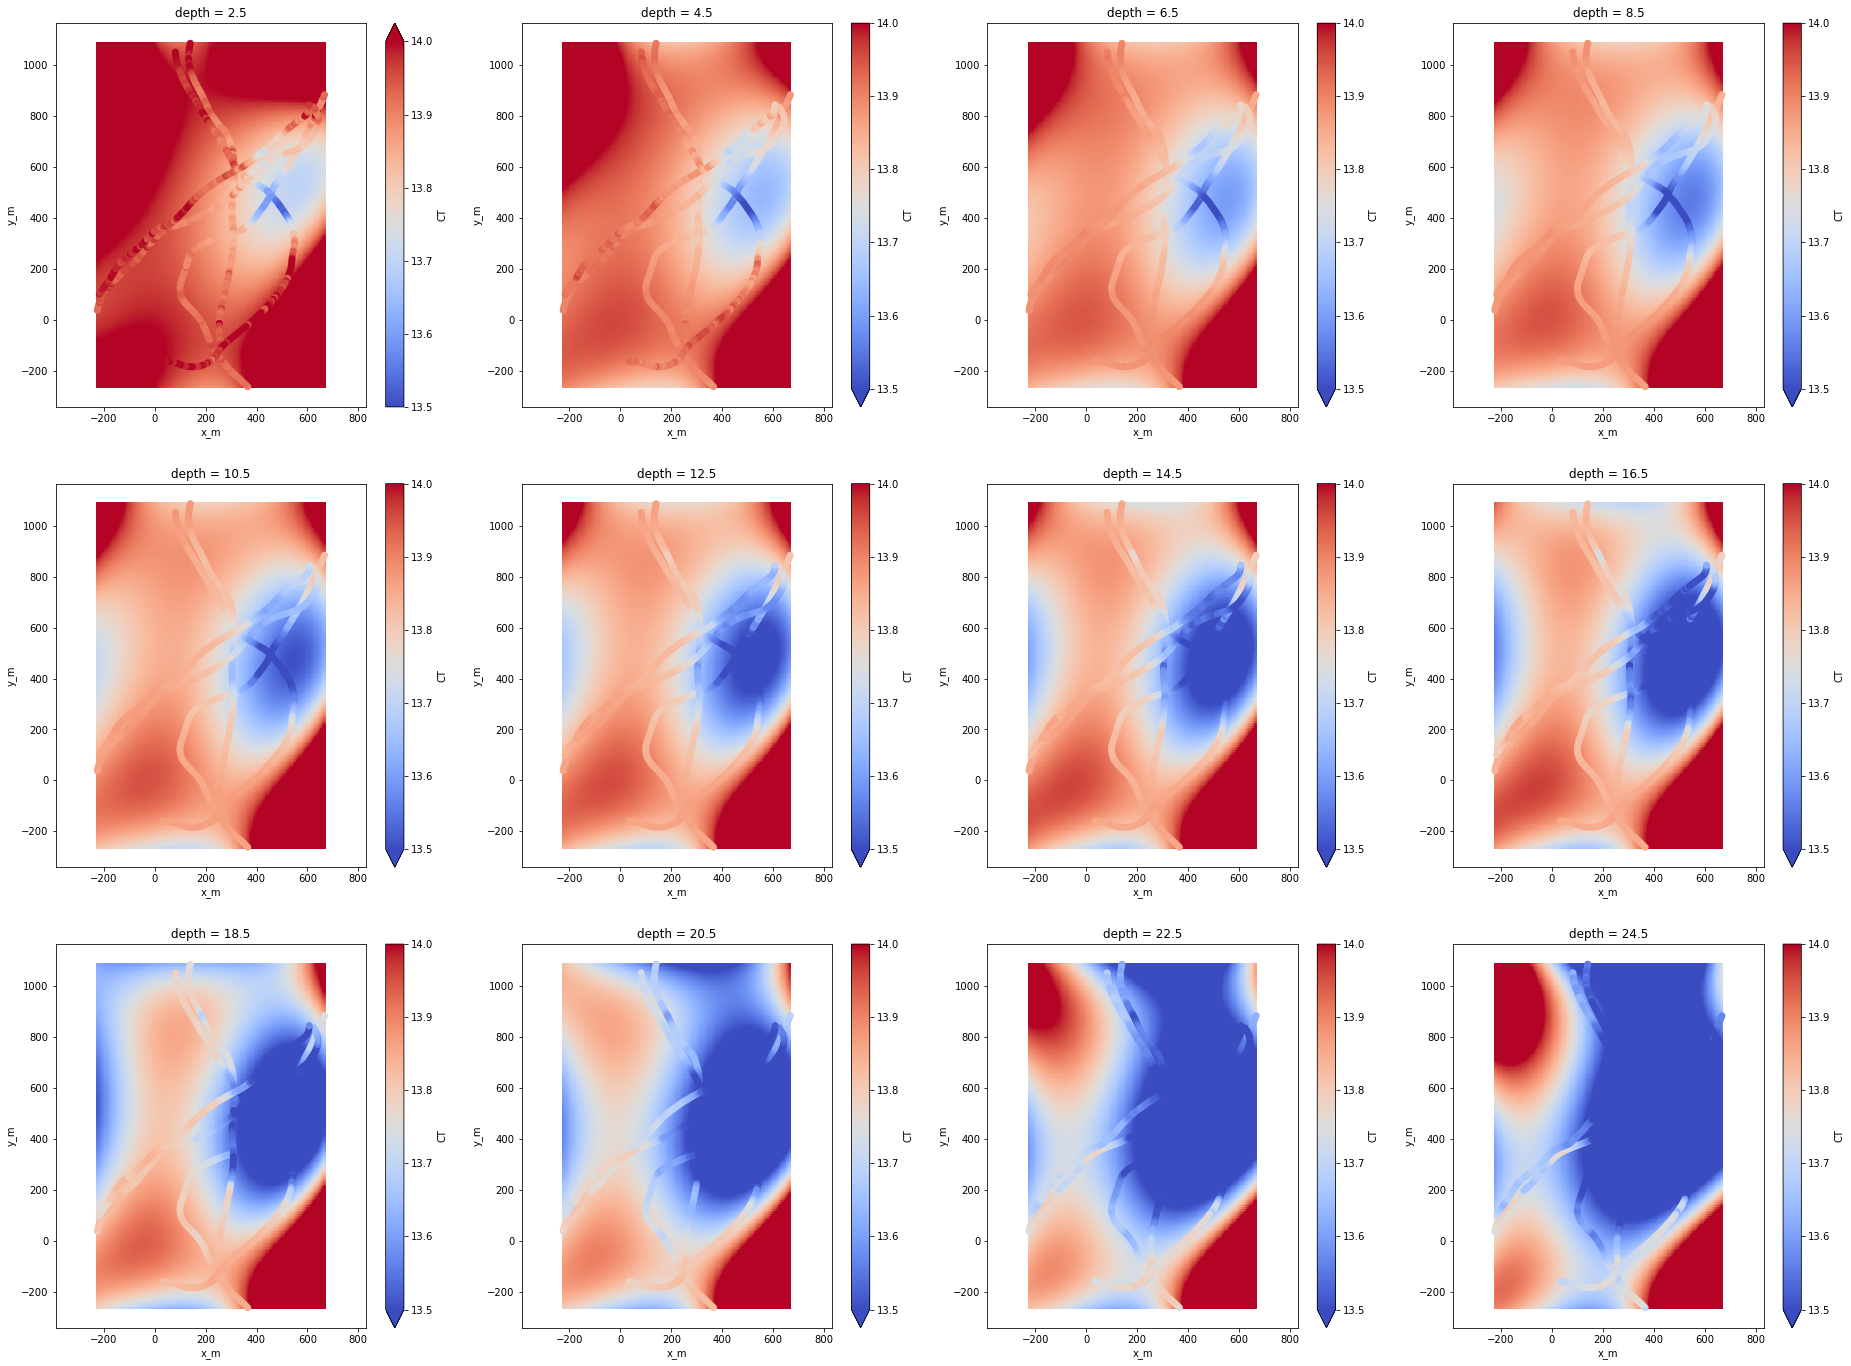

In [6]:
%matplotlib inline

# plotting the original (scatter) and estimated (grid) temperature at all depths
nrows, ncols =  3,4
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*8.,nrows*8))
axs = axs.ravel()
si = 0
for z_sel in tia_gpr_allz.depth[1:]:
    tia_gpr_allz.CT.sel(depth=z_sel,method='nearest').plot(x='x_m',y='y_m',cmap='coolwarm',ax=axs[si],vmin=13.5,vmax=14.,add_colorbar=False)
    tia_all.sel(depth=z_sel,method='nearest').plot.scatter(x='x_m',y='y_m',hue='CT',
                                                           cmap='coolwarm',ax=axs[si],vmin=13.5,vmax=14.)
    axs[si].axis('equal')
    si = si +1

/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/dataarray.py:1913: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Z contains NaN values. This may result in rendering artifacts.


Text(0.5, 1.0, 'Original transect 13 [$^\\circ$C]')

/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


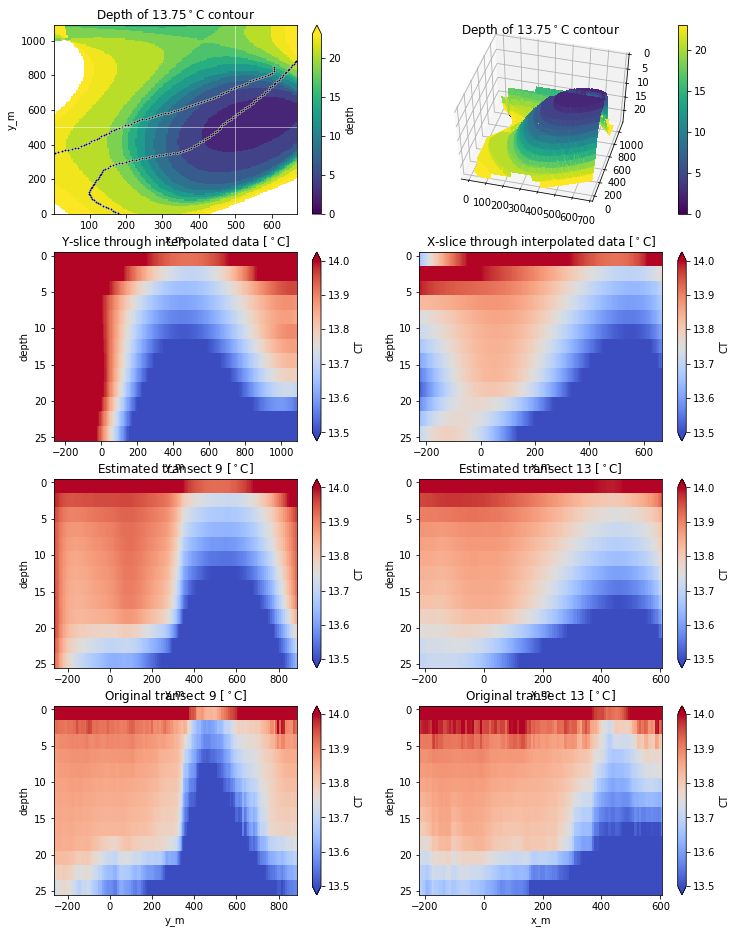

In [25]:
%matplotlib inline
#widget

# plotting slice at select temperature; first set upper limit, then use max to avoid having to interpolate
# CT which doesn't seem to be possible (only coords)

# set upper limit, then take max below
tia_13 = tia_gpr_allz.where(tia_gpr_allz.CT < 13.75)
# at which depth is this upper limit temperature found - this is plotted
tia_13['depth'] = tia_13.depth.where(tia_gpr_allz.CT==tia_13.CT.max(dim='depth')).max(dim='depth')
tia_13 = tia_13.sel(x_m=slice(0,1200),y_m=slice(0,1200))

nrows,ncols = 4,2
fig, axs = plt.subplots(figsize=(ncols*6.,nrows*4))#,nrows=nrows,ncols=ncols,subplot_kw={'projection': '3d'}) 
axs = [None]*nrows*ncols

si = 0
axs[si] = plt.subplot(nrows, ncols, si+1)
tia_13.depth.plot(x='x_m',ax=axs[si],vmin=0,vmax=23)
plt.title('Depth of 13.75$^\circ$C contour')
plt.axhline(500,color='w',linewidth=0.5)
plt.axvline(500,color='w',linewidth=0.5)
(tia_all.sel(time=slice(tia['Transect13'].time[0],tia['Transect13'].time[-1]))).plot.scatter(x='x_m',y='y_m',s=3,color='w',ax=axs[si])
(tia_all.sel(time=slice(tia['Transect9'].time[0],tia['Transect9'].time[-1]))).plot.scatter(x='x_m',y='y_m',s=3,color='w',ax=axs[si])
x_int9 = tia_all.sel(time=slice(tia['Transect9'].time[0],tia['Transect9'].time[-1])).x_m
y_int9 = tia_all.sel(time=slice(tia['Transect9'].time[0],tia['Transect9'].time[-1])).y_m
tia_gpr_allz.interp(x_m=x_int9,y_m=y_int9).plot.scatter(x='x_m',y='y_m',ax=axs[si],s=1,color='k')
x_int13 = tia_all.sel(time=slice(tia['Transect13'].time[0],tia['Transect13'].time[-1])).x_m
y_int13 = tia_all.sel(time=slice(tia['Transect13'].time[0],tia['Transect13'].time[-1])).y_m
tia_gpr_allz.interp(x_m=x_int13,y_m=y_int13).plot.scatter(x='x_m',y='y_m',ax=axs[si],s=1,color='k')

si = 1
axs[si] = plt.subplot(nrows, ncols, si+1,projection='3d')
LON = np.array([tia_13.x_m.values,]*tia_13.y_m.shape[0]).squeeze() # copy rows
LAT = np.array([tia_13.y_m.values,]*tia_13.x_m.shape[0]).squeeze().T
surf = axs[si].plot_surface(LON,LAT, tia_13.depth.T,cmap='viridis',vmin=0,vmax=23,
                          rstride=1, cstride=1, antialiased=False)
axs[si].set_zlim(24,0)
axs[si].view_init(50, -75)
plt.title('Depth of 13.75$^\circ$C contour')
plt.colorbar(surf)

# add slices through estimated data for comparison
si = 2
axs[si] = plt.subplot(nrows, ncols, si+1)
tia_gpr_allz.CT.sel(x_m=500,method='nearest').plot(ax=axs[si],cmap='coolwarm',
                                                    vmin=13.5,vmax=14.,yincrease=False)
plt.title('Y-slice through interpolated data [$^\circ$C]')

si = 3
axs[si] = plt.subplot(nrows, ncols, si+1)
tia_gpr_allz.CT.sel(y_m=500,method='nearest').plot(ax=axs[si],cmap='coolwarm',
                                                    vmin=13.5,vmax=14.,yincrease=False)
plt.title('X-slice through interpolated data [$^\circ$C]')

# add slices along original transects using estimated data
si = 4
axs[si] = plt.subplot(nrows, ncols, si+1)
tia_gpr_allz.CT.interp(x_m=x_int9,y_m=y_int9).plot(x='y_m',y='depth',ax=axs[si],cmap='coolwarm',
                                                    vmin=13.5,vmax=14.,yincrease=False)
plt.title('Estimated transect 9 [$^\circ$C]')

si = 5
axs[si] = plt.subplot(nrows, ncols, si+1)
tia_gpr_allz.CT.interp(x_m=x_int13,y_m=y_int13).plot(x='x_m',y='depth',ax=axs[si],cmap='coolwarm',
                                                    vmin=13.5,vmax=14.,yincrease=False)
plt.title('Estimated transect 13 [$^\circ$C]')


# add transect sections from original data for comparison
si = 6
axs[si] = plt.subplot(nrows, ncols, si+1)
(tia_all.sel(time=slice(tia['Transect9'].time[0],tia['Transect9'].time[-1])).
     swap_dims({'time': 'y_m'}).CT).plot(x='y_m',y='depth',yincrease=False,cmap='coolwarm',ax=axs[si],
                                                    vmin=13.5,vmax=14.)
plt.title('Original transect 9 [$^\circ$C]')

si = 7
axs[si] = plt.subplot(nrows, ncols, si+1)
(tia_all.sel(time=slice(tia['Transect13'].time[0],tia['Transect13'].time[-1])).
     swap_dims({'time': 'x_m'}).CT).plot(x='x_m',y='depth',yincrease=False,cmap='coolwarm',ax=axs[si],
                                                    vmin=13.5,vmax=14.)
plt.title('Original transect 13 [$^\circ$C]')
